### Introduction
### Create a model that can accurately predict whether a user belongs to the HCP(Healthcare Professional) category and its specialization id/taxonomy based on ad server logs information.

### Import the necessary packages.

In [108]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import copy
import random

from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer

from sklearn.model_selection import  cross_val_score,KFold,train_test_split,ShuffleSplit,StratifiedKFold,learning_curve
from catboost import CatBoostClassifier,Pool,cv,monoforest
import optuna

from optuna.samplers import RandomSampler,TPESampler,MOTPESampler,CmaEsSampler
from sklearn.metrics import r2_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,accuracy_score

import math

import shap
shap.initjs()



### Import train and test dataset

In [139]:
train=pd.read_csv("/kaggle/input/doceree-machine-learning-hackathon-1/Doceree_Complete_DataSet/Doceree-HCP_Train.csv", encoding='ISO-8859-1')
test=pd.read_csv("/kaggle/input/doceree-machine-learning-hackathon-1/Doceree_Complete_DataSet/Doceree-HCP_Test.csv", encoding='ISO-8859-1')
         

### Combine train and test data

In [140]:
train['data']='train'
test['data']='test'

In [141]:
full_data=pd.concat([train,test],axis=0)

### Function for pre-process the data

In [142]:
def pre_process(df):
    #change column names to lowercase
    df=df.rename(columns={col:col.lower() for col in df.columns})
    #extract device information (windows, iphone, andriod, etc.)
    df['device_info']=df['useragent'].str.extract("([a-z|A-Z|0-9|\s|.|,]+;)")
    df['device_info']=df['device_info'].str.replace(";","")
    df['device_info']=df['device_info'].fillna("Windows NT 10.0")
    
    def device_brand_name(row):
        if re.match("Windows|X11",row):
            return "microsoft"
        elif re.match("Android",row):
            return 'andriod'
        elif re.match("Linux",row):
            return 'linux'
        elif re.match("Macintosh|iPad|iPod|iPhone",row):
            return 'apple'
        elif re.match("KHTML, like Gecko|compatible",row):
            return 'other'
    
        
    df['brand_name']=df['device_info'].apply(lambda x:device_brand_name(x))
    
    #extract browser information
    df['browser']=df['useragent'].apply(lambda x:"_".join(re.findall("(Mozilla|Chrome|Safari)",str(x))))
    #extract site information
    df['site_name']=df['url'].str.extract("https?://(www.|consumer.|.uat)?(\w+)(.com|.org)?")[1]
    #extract domain name
    df['domain_name']=df['url'].str.extract("(.com|.org)")
    #extract site prefix
    df['site_prefix']=df['url'].str.extract("https?://(www.|consumer.|.uat)?")
    df['site_prefix']= df['site_prefix'].fillna("none")
    #extract search infor from url
    df['search_info']=df['url'].str.extract("https?://(www.|consumer.|.uat)?(\w+)(.com|.org)?(.+)")[3]
    df['search_info']=df['search_info'].str.replace("[^\w\s]|home|articles|topics|slang|code|words|[0-9]|[…\u2026]+"," ")
    df['search_info']=df['search_info'].apply(lambda x:x.strip())
    df['search_info']=df['search_info'].apply(lambda x:" ".join(i for i in x.split() if len(i)>5 ))
    #fill missing value for column userplatformuid
    df['userplatformuid']=df['userplatformuid'].fillna("undefined")
    df['userplatformuid_len']=df['userplatformuid'].apply(lambda x: len(x))
    #replace keywords category keywords
    df['keywords']=df['keywords'].str.replace("covid-19","covid")
    
   
    #unique ip address count
    df["ip_user_count"]=df.groupby('bidrequestip')['bidrequestip'].transform('count')
    
    #groupby count of categorical column level
    for col in ['devicetype', 'userplatformuid', 'platformtype',
       'channeltype', 'keywords', 'device_info', 'brand_name', 'browser',
       'site_name', 'domain_name', 'site_prefix']:
        df[f"ip_{col}_count"]=df.groupby('bidrequestip')[col].transform('count')
    
    
    return df

### Apply pre-process to combined data

In [143]:
full_data=pre_process(full_data)

### Split train and test data from comined data.

In [144]:
train=full_data[full_data['data']=='train']
test=full_data[full_data['data']=='test']


### Target column has null value remove the null value from the train data and split predictor and response column.

In [145]:
train1=train[train['is_hcp'].notnull()]

In [146]:
train1.head(2)

,id,devicetype,platform_id,bidrequestip,userplatformuid,usercity,userzipcode,useragent,platformtype,channeltype,...,ip_userplatformuid_count,ip_platformtype_count,ip_channeltype_count,ip_keywords_count,ip_device_info_count,ip_brand_name_count,ip_browser_count,ip_site_name_count,ip_domain_name_count,ip_site_prefix_count
0,1001,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,Website,...,34,34,34,34,34,34,34,34,34,34
1,1002,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,Website,...,728,728,728,728,728,728,728,728,728,728


In [163]:
for i,col in enumerate(train.columns):
    print(f"{i}_{col}")

0_id
1_devicetype
2_platform_id
3_bidrequestip
4_userplatformuid
5_usercity
6_userzipcode
7_useragent
8_platformtype
9_channeltype
10_url
11_keywords
12_taxonomy
13_is_hcp
14_data
15_device_info
16_brand_name
17_browser
18_site_name
19_domain_name
20_site_prefix
21_search_info
22_userplatformuid_len
23_ip_user_count
24_ip_devicetype_count
25_ip_userplatformuid_count
26_ip_platformtype_count
27_ip_channeltype_count
28_ip_keywords_count
29_ip_device_info_count
30_ip_brand_name_count
31_ip_browser_count
32_ip_site_name_count
33_ip_domain_name_count
34_ip_site_prefix_count


In [148]:
X=train1.iloc[:,np.r_[1,2,3,4,8,9,11,15,16,17,18,19,20,22:35]]
y=train1['is_hcp']

### Split the train dataset to evaluate the model.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42,
                                                   stratify=y
                                                   )

### Store X_train and y_train features in new object.

In [150]:
X1=X_train
y1=y_train


### Create catboost model and tune the hyperparameters by using optuna framework.

In [ ]:
def objective(trial):
    skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(X1,y1)):
        X_train, X_valid = X1.iloc[train_index], X1.iloc[test_index]
        y_train, y_valid = y1.iloc[train_index], y1.iloc[test_index]
        param = {

            'l2_leaf_reg':trial.suggest_float('reg_lambda',1e-3, 1e-1, log=True),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            'n_estimators': trial.suggest_int('n_estimators',50,1000),
            'max_depth': trial.suggest_int('max_depth', 1,10),
            'random_state': trial.suggest_categorical('random_state', [100,200,300,400,500]),
           "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01,0.1,log=True),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", 
                                                                         #"Plain"
                                                                        ]),
            #"auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced","SqrtBalanced"]),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",1, 100),
           'random_strength': trial.suggest_uniform('random_strength', 0.1, 1.0),
            'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            'od_wait':trial.suggest_int("od_wait", 1, 200),
           # "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree","Depthwise",
                                                                     #   "Lossguide"]),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", [#"Bayesian", 
                                                                           "Bernoulli",
                            # "MVS"
                              ]
            ),
            }
        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        cat_clf = CatBoostClassifier(#early_stopping_rounds=100,
                                     eval_metric="Accuracy",#grow_policy='Lossguide',
                                   logging_level="Silent",#ask_type='GPU',
                                  **param)
      #  pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
        cat_clf.fit(X_train, y_train,eval_set=[(X_valid,y_valid)],
                    cat_features=X.select_dtypes(include='object').columns.values ,
                   # callbacks=[pruning_callback]
                   )
        #pruning_callback.check_pruned()

        preds = cat_clf.predict(X_test)
        #preds_prob = cat_clf.predict_proba(X_test)[:,1]
        #accuracy_roc = roc_auc_score(y_test, preds_prob)
        accuracy = accuracy_score(y_test, preds)
        return accuracy



if __name__ == "__main__":
    study = optuna.create_study(direction='maximize',sampler=MOTPESampler(),
           pruner=optuna.pruners.SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)  

### The best score and parameters.

In [156]:

#best score:0.9971914221351043, 
param_cat={'reg_lambda': 0.0014405457602774771,
  'learning_rate': 0.07407716861452632,
  'n_estimators': 337,
  'max_depth': 11,
  'random_state': 500,
  'colsample_bylevel': 0.07909236642985043,
  'boosting_type': 'Ordered',
  'min_data_in_leaf': 65,
  'random_strength': 0.6165465858539836,
  'od_type': 'IncToDec',
  'od_wait': 126,
  'bootstrap_type': 'Bernoulli',
  'subsample': 0.2963287716736031}


### Fit catboost classifier with tuned parameters.

In [172]:
eval_cat_clf = CatBoostClassifier(#early_stopping_rounds=30,
    eval_metric="Accuracy",logging_level="Silent", **param_cat)
eval_cat_clf.fit(X_train, y_train,eval_set=(X_test,y_test), 
            cat_features=X_train.select_dtypes(include='object').columns.values)


In [197]:
val_predict=eval_cat_clf.predict(X_test)
print(f"Validation Data Accuracy:{accuracy_score(y_test,val_predict)}")

Validation Data Accuracy:0.9980105906790322


### Validation data Confusion matrix

In [198]:
def confusion_matrix_plot(y_true,predicted):
    fig, (ax1) = plt.subplots(nrows=1, figsize=(8, 5))
    conf=confusion_matrix(y_true,predicted)
    conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf, annot=True,  cmap="Blues",fmt=".2%");
    ax1.set_title("Confusion Matrix\n")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("True")
    ax1.yaxis.set_ticklabels([0,1],rotation=0);

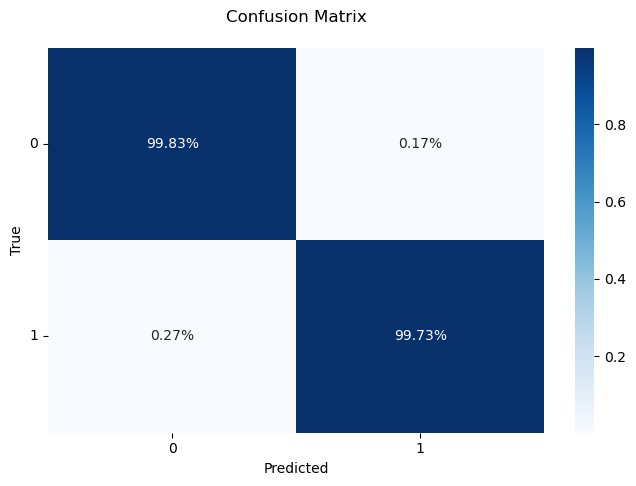

In [199]:
confusion_matrix_plot(y_test,val_predict)

In [151]:
cat_clf = CatBoostClassifier(#early_stopping_rounds=30,
    eval_metric="Accuracy", **param_cat)
cat_clf.fit(X,y,#X_train, y_train,eval_set=(X_test,y_test), 
            cat_features=X.select_dtypes(include='object').columns.values)


0:	learn: 0.9865187	total: 64.7ms	remaining: 21.8s
1:	learn: 0.9865187	total: 117ms	remaining: 19.6s
2:	learn: 0.9865187	total: 169ms	remaining: 18.9s
3:	learn: 0.9865187	total: 210ms	remaining: 17.4s
4:	learn: 0.9869225	total: 659ms	remaining: 43.8s
5:	learn: 0.9876071	total: 876ms	remaining: 48.3s
6:	learn: 0.9905649	total: 946ms	remaining: 44.6s
7:	learn: 0.9909335	total: 1.46s	remaining: 1m
8:	learn: 0.9909247	total: 1.52s	remaining: 55.4s
9:	learn: 0.9908545	total: 1.58s	remaining: 51.8s
10:	learn: 0.9912670	total: 2.02s	remaining: 59.8s
11:	learn: 0.9918902	total: 2.3s	remaining: 1m 2s
12:	learn: 0.9918200	total: 2.4s	remaining: 60s
13:	learn: 0.9917673	total: 2.72s	remaining: 1m 2s
14:	learn: 0.9916269	total: 2.77s	remaining: 59.4s
15:	learn: 0.9916708	total: 2.88s	remaining: 57.8s
16:	learn: 0.9919867	total: 3.25s	remaining: 1m 1s
17:	learn: 0.9920043	total: 3.4s	remaining: 1m
18:	learn: 0.9922237	total: 3.75s	remaining: 1m 2s
19:	learn: 0.9923729	total: 4.15s	remaining: 1m 5s


### Feature importances Catboost model(default interpretation).

In [157]:
def feature_imp_plot(df,feat_imp_score,title="" ):
    _=plt.figure(figsize=(12,6))
    feat_importance=pd.DataFrame({'columns':df.columns,'score':feat_imp_score})
    feat_importance=feat_importance.sort_values('score',ascending=False)
    _=sns.barplot(data=feat_importance.nlargest(10,'score'),x='score',y='columns')
    plt.title(f"{title}",fontsize=16);

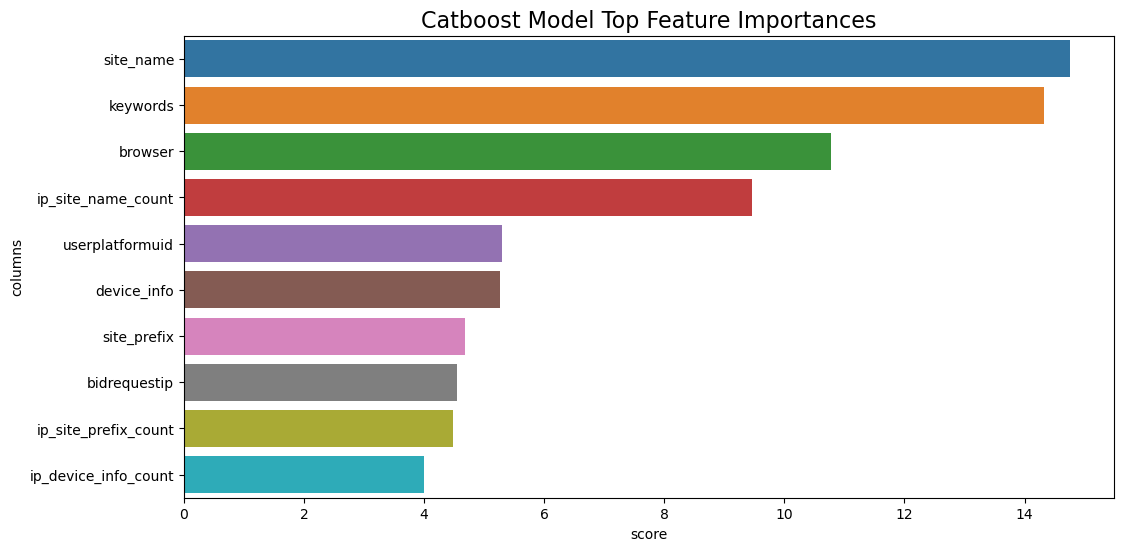

In [159]:
feature_imp_plot(X,cat_clf.get_feature_importance(),"Catboost Model Top Feature Importances")

### Interpret model with SHAP

In [160]:
explainer = shap.TreeExplainer(cat_clf)
shap_values = explainer.shap_values(X, y)

### Feature importances plot

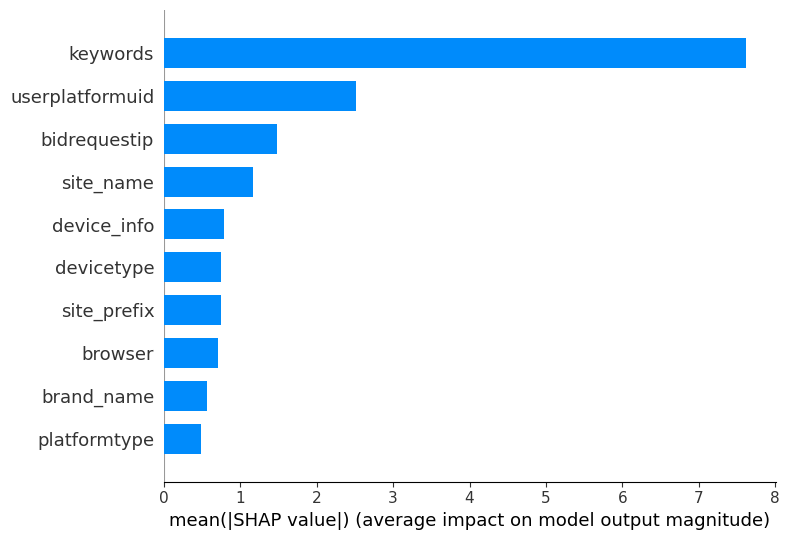

In [165]:
shap.summary_plot(shap_values, X, plot_type="bar",
                  max_display=10)

### Top features impact the model

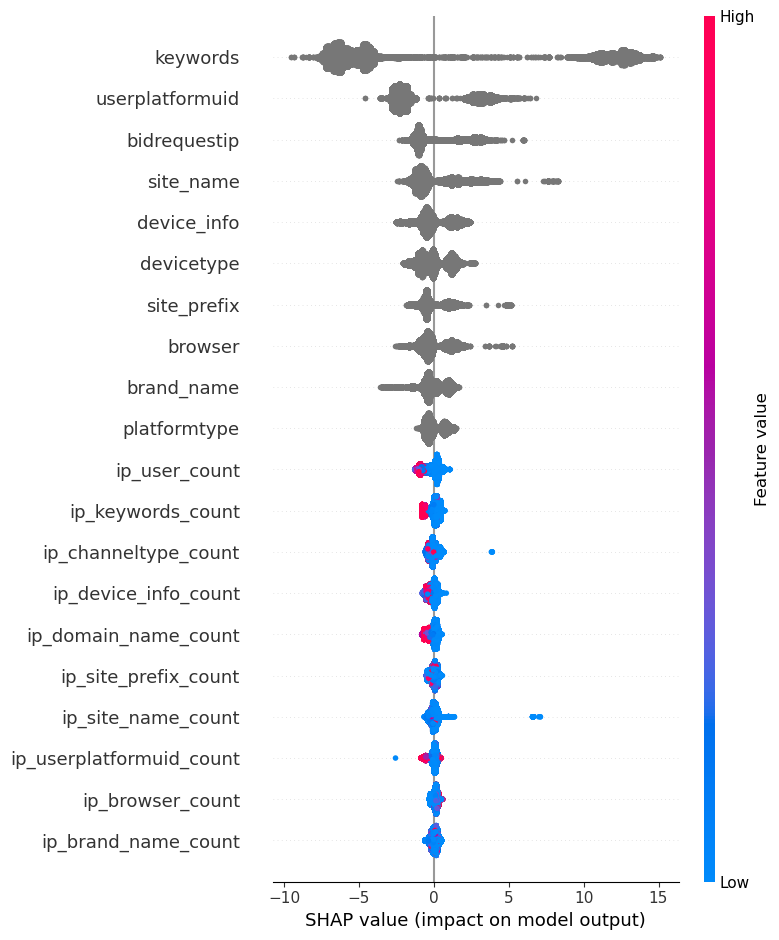

In [167]:
shap.summary_plot(shap_values, X)

### Let's see which feature influences the model prediction for a single observation in each class.

### Top feature influences for class 1

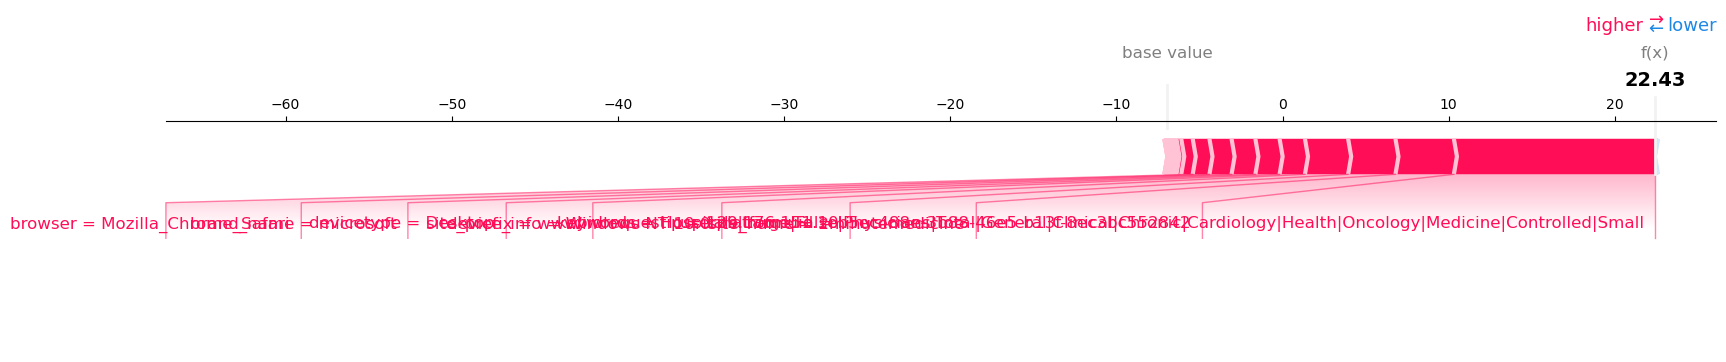

In [168]:
shap.force_plot(explainer.expected_value, shap_values[191,:], X.iloc[191,:],matplotlib=True)

### Top feature influences for class 0

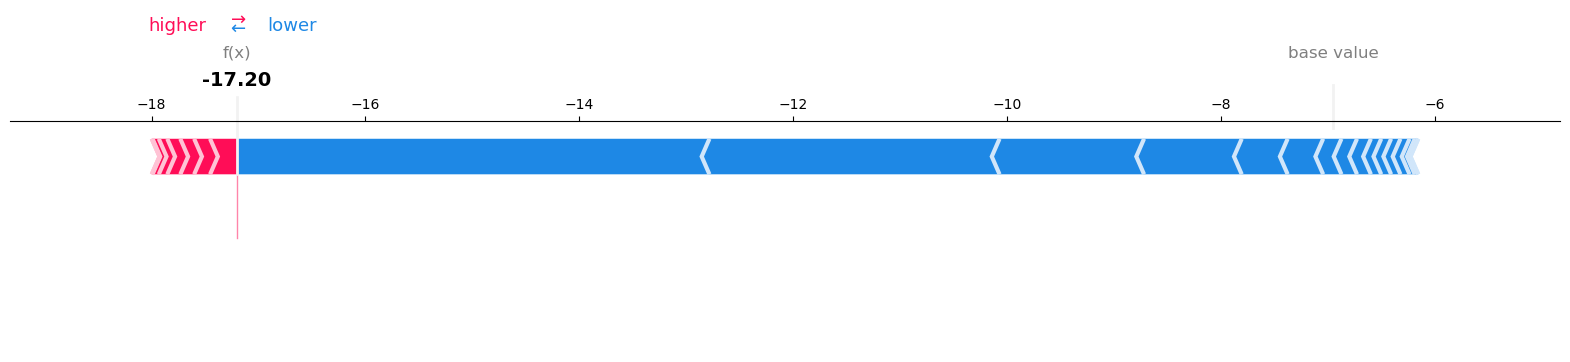

In [169]:
shap.force_plot(explainer.expected_value, shap_values[56,:], X.iloc[56,:],matplotlib=True)

### Overall Train and Validation Accuracy

In [211]:
def overall_logloss(model):
    fig=plt.figure(figsize=(8,5))
    _=plt.plot(model.evals_result_['learn']['Accuracy'],marker=".",label="Train")
    _=plt.plot(model.evals_result_['validation']['Accuracy'],marker=".",label="Validation")
    _=plt.ylabel("Accuracy",fontsize=15)
    _=plt.xlabel("Iterations",fontsize=15)
    _=plt.title("Catboost Model Overall Train and Validation Accuracy \n",fontsize=18)
    plt.legend()
    plt.show()

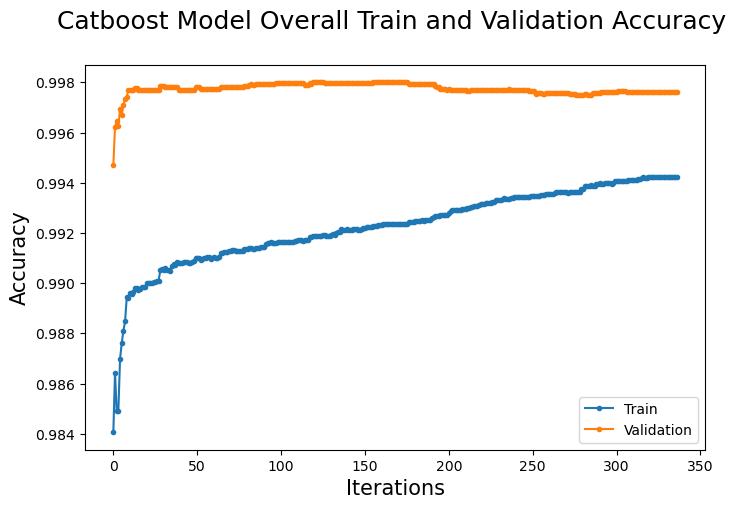

In [212]:
overall_logloss(eval_cat_clf)

### Predict the test data

In [152]:
test_pre=cat_clf.predict(test.loc[:,X.columns])

### Create result dataframe

In [153]:
res=pd.DataFrame({'ID':test['id'],'IS_HCP':test_pre})

In [154]:
res['IS_HCP'].value_counts()

0.0    20026
1.0     8467
Name: IS_HCP, dtype: int64

### Write the result dataframe to csv

In [155]:
res.to_csv("catboost_optuna_final.csv",index=False)